# DOTA - Churn Prediction
## Considerations
### Imports

In [1]:
#Data Processing
import pandas as pd
import matplotlib
import seaborn
import numpy as np
import matplotlib.pyplot as plt

#Machine Learning
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

#Options
%matplotlib inline
seaborn.set()

### Data Import
First we import the data gathered from our crawler

In [2]:
data = pd.read_csv("../data/dota_matches_Full.csv", sep=",")

/home/dany/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,43,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Preprocessing
Not all features gathered are necessary to predict churn and we need to get rid of anonymous players.

In [3]:
def preprocess_data(data):
    #just select needed features
    processed_data = pd.DataFrame(data, columns = ['account_id', 'kills', 'deaths', 'assists', 'last_hits', 'denies', 'hero_damage', 'tower_damage', 'gold_spent', 'xp_per_min', 'level', 'player_slot', 'radiant_win', 'duration', 'start_time'])
    
    #delete data for anonymous players
    processed_data = processed_data.loc[data['account_id'] != 4294967295] #anonymous players have an account id of max integer, drops ~28% of our data
    
    #sort everything by time
    processed_data.sort_values(by = 'start_time', inplace = True)
    
    #13% of our data (same observations) has missing values for hero_damage, tower_damage and gold_spent
    processed_data.dropna(how="any", inplace=True)

    return processed_data
    
data = preprocess_data(data)

## Exercise 1: Data Labeling
We use time churn to check whether a match is a churn match. For this we need to handle the last match of a player. We decided to drop the last match as we cannot predict the future. We also tried to get the latest match of the whole data set and then compare it to the last match of a specific player, but we couldn't get it to work.

In [4]:
TIME_CHURN_THRESHOLD = 604800  #= 1 Week

def is_churn_match(data):
    data.sort_values(by = 'start_time', ascending="False", inplace = True)
    data['time_to_next'] = data.groupby(['account_id'])['start_time'].transform(lambda x: x.diff())
    data.sort_values(by = 'start_time', inplace = True)
    
    data['isChurnMatch'] = data['time_to_next'] >= TIME_CHURN_THRESHOLD
    data['time_to_next'].fillna(0)
    
    #drop last match
    data.groupby(['account_id'], as_index=False).apply(lambda x: x.iloc[:-1])

is_churn_match(data)
data

account_id  kills  deaths  assists  last_hits  denies  hero_damage  \
25621     58320148    6.0     3.0     11.0       39.0     0.0      10281.0   
25627     58320148   10.0    10.0      6.0       44.0     0.0      10067.0   
25633     93311931    6.0     7.0     19.0       99.0     3.0      11238.0   
25636     17164642    4.0     7.0      7.0       25.0     6.0      10805.0   
25640    152135382    9.0     4.0     10.0      239.0     3.0      13687.0   
25644     17164642    3.0     2.0      3.0      196.0    10.0       6725.0   
25650     37979027   14.0     9.0     11.0       84.0     8.0      18500.0   
25651     58320148    4.0    10.0     14.0      186.0     0.0      10167.0   
25654    152135382    3.0     7.0      5.0      187.0     2.0       6469.0   
25659    124236210   15.0    11.0      3.0      158.0     4.0      25846.0   
25665    192731297    1.0     8.0      4.0       47.0     1.0       3289.0   
25674     38440257    2.0     6.0     19.0       86.0     1.0      11113.0   
25673     17164642    9.0     3.0     10.0      107.0     5.0      10843.0   
25677     86730329    4.0     2.0     20.0      125.0    11.0      14417.0   
25678     98533579    1.0     4.0      2.0       31.0     0.0       2928.0   
25681     17164642    5.0     6.0     15.0      205.0     2.0      13398.0   
25682     38440257   21.0     5.0      7.0      366.0     5.0      22206.0   
25684     17164642    7.0    11.0     21.0      114.0     6.0      13161.0   
25685     38440257    4.0     8.0     17.0      130.0     4.0       6072.0   
25687     38158958   18.0     5.0     22.0      338.0    19.0      32326.0   
25695    152135382   10.0     7.0      9.0      147.0     1.0      14160.0   
25699    152135382    6.0     3.0     16.0       27.0     0.0      10502.0   
25703     38158958   18.0    12.0     23.0      131.0     6.0      26407.0   
25704     38440257   10.0    19.0     26.0       82.0     5.0      13720.0   
25712     58320148    8.0     8.0      7.0       21.0     0.0       9635.0   
25711     37979027   11.0     8.0     12.0       38.0     1.0      19264.0   
25718    152135382   21.0     2.0      6.0      197.0     0.0      20933.0   
25723    152135382   18.0     4.0      9.0      157.0     1.0      23480.0   
25731     17164642   11.0     8.0     18.0       31.0     0.0      13331.0   
25734     98533579    4.0    11.0      5.0      178.0    14.0       9421.0   
...            ...    ...     ...      ...        ...     ...          ...   
181637    40130090    2.0     2.0     14.0      143.0     8.0       5319.0   
181643   279050976    2.0     7.0     23.0       40.0     2.0       3378.0   
181649   227067099   13.0     1.0     18.0      208.0    10.0      18733.0   
181651   191545129   11.0    10.0     17.0      359.0     3.0      17338.0   
181654    52249040    8.0    10.0     10.0      247.0    16.0      11074.0   
181658    59054967    9.0     3.0      9.0       91.0     7.0      13023.0   
181659   158337963    0.0     1.0      0.0        5.0     7.0       1518.0   
181661   227799727   10.0     7.0     19.0      107.0     1.0      14710.0   
181671   158337963    2.0     8.0     11.0       11.0     4.0       5514.0   
181674   163935343    4.0    11.0     14.0       64.0     3.0       7283.0   
181675   227067099    3.0     6.0      7.0      261.0     7.0      11965.0   
181676   231937303   12.0     3.0      5.0      223.0     3.0      17204.0   
181679    86895257    5.0    11.0     18.0       71.0     2.0      11630.0   
181685   279050976    9.0    10.0     13.0      167.0     1.0      13969.0   
181687    52249040    9.0    11.0     20.0      161.0     5.0      13770.0   
181690    59054967    5.0    11.0     17.0      156.0    10.0      15901.0   
181693   163935343    8.0     8.0      9.0      156.0    12.0      17862.0   
181699   158337963   16.0     6.0      8.0      357.0     0.0      25522.0   
181706   260291992    2.0    14.0      0.0        9.0     1.0       1714.0   
181708   227067099   13.0     

## Exercise 2: Feature Engineering
General note: Sometimes our attribute is 0 and duration 0, so that the resulting number will be NaN. Instead of fixing it here, we fix it in the feature generation

### Match Attributes
We normalized the values by game duration. The duration is measured in seconds.

In [5]:
def feature_kills(data):
    res = data.kills / (data.duration / 60)
    return np.asarray(res), ['kills_per_min']

In [6]:
data['kills_n'] = data['kills'] / data['duration']
data[data['kills_n'].isnull()]

account_id  kills  deaths  assists  last_hits  denies  hero_damage  \
42675    123170224    0.0     0.0      0.0        0.0     0.0          0.0   
68592    267955736    0.0     0.0      0.0        0.0     0.0          0.0   
110899    92955742    0.0     0.0      0.0        0.0     0.0          0.0   
128351   125372623    0.0     0.0      0.0        0.0     0.0          0.0   
163900    97931627    0.0     0.0      0.0        0.0     0.0          0.0   

        tower_damage  gold_spent  xp_per_min  level  player_slot radiant_win  \
42675            0.0         0.0         0.0    1.0        132.0       False   
68592            0.0         0.0         0.0    1.0          1.0       False   
110899           0.0         0.0         0.0    0.0        128.0        True   
128351           0.0         0.0         0.0    1.0          0.0        True   
163900           0.0         0.0         0.0    0.0        129.0       False   

        duration  start_time  time_to_next isChurnMatch  kills_n  
42675          0  1437855435       65465.0        False      NaN  
68592          0  1450265578        3328.0        False      NaN  
110899         0  1457716411       10504.0        False      NaN  
128351         0  1460142548        2595.0        False      NaN  
163900         0  1464294303        1860.0        False      NaN

In [7]:
def feature_deaths(data):
    res = data.deaths / (data.duration / 60)
    return np.asarray(res), ['deaths_per_min']

In [8]:
def feature_assists(data):
    res = data.assists / (data.duration / 60)
    return np.asarray(res), ['assists_per_min']

In [9]:
def feature_last_hits(data):
    res = data.last_hits / (data.duration / 60)
    return np.asarray(res), ['last_hits_per_min']

In [10]:
def feature_denies(data):
    res = data.denies / (data.duration / 60)
    return np.asarray(res), ['denies_per_min']

In [11]:
def feature_hero_dmg(data):
    res = data.hero_damage / (data.duration / 60)
    return np.asarray(res), ['hero_dmg_per_min']

In [12]:
def feature_tower_dmg(data):
    res = data.tower_damage / (data.duration / 60)
    return np.asarray(res), ['tower_dmg_per_min']

### Additional Features
Additional features checking how good the player / team has performed. We also wanted a feature "gold per minute" but it was missing in our data set even though it is available through the API.

In [13]:
def feature_gold_spent(data):
    res = data.gold_spent / (data.duration / 60)
    return np.asarray(res), ['gold_spent_per_min']

In [14]:
def feature_hero_lvl(data):
    return np.asarray(data['level']), ['hero_lvl']

In [15]:
def feature_xp(data):
    return np.asarray(data['xp_per_min']), ['xp_per_min']

In [16]:
def feature_win(data):
    data['team_radiant'] = data.player_slot <= 4 
    res = (data.team_radiant == data.radiant_win)
    return np.asarray(res), ['win']

In [17]:
def feature_kda(data):
    res = (data.kills + data.assists) / np.maximum(1, data.deaths)
    return np.asarray(res), ['kda']

### Time Features

In [18]:
def feature_time_to_previous_match(data):
    data['time_to_next_previous_match'] = data.groupby(['account_id'])['start_time'].transform(lambda x: x.diff())
    return np.asarray(data['time_to_next_previous_match']), ['time_to_previous_match']

In [19]:
def feature_avg_time_between_sessions(data):
    accountU = data['account_id'].unique()
    accountid = data['account_id'].as_matrix()
    start_time = pd.to_numeric(data['start_time']).as_matrix()
    duration = pd.to_numeric(data['duration']).as_matrix()

    df = np.zeros(data.shape[0])

    tempFrame = np.zeros((accountU.size, 4))


    for i in range(0, data.shape[0]):

        for a in range(0, accountU.size):

            if (accountid[i] == accountU[a]):

                if (tempFrame[a][0] == 0):

                    tempFrame[a][0] = start_time[i] + duration[i]

                else:
                    
                    tempFrame[a][1] = start_time[i]
                    tempFrame[a][2] = tempFrame[a][2] + (tempFrame[a][1] - tempFrame[a][0])
                    tempFrame[a][3] = tempFrame[a][3] + 1
                    df[i] = tempFrame[a][2] / tempFrame[a][3]
                    tempFrame[a][0] = start_time[i] + duration[i]

    dFrame = pd.DataFrame(np.asarray(df))
    #dFrame = (dFrame - dFrame.mean()) / dFrame.std()
    
    return np.asarray(dFrame), ['avg_time_between_session']

In [20]:
def feature_avg_session_length(data):
    accountU = data['account_id'].unique()
    duration = pd.to_numeric(data['duration'].as_matrix())
    accountid = data['account_id'].as_matrix()
    df = np.zeros(data.shape[0])
    tempFrame = np.zeros((accountU.size, 2))


    for i in range(0, data.shape[0]):

        for a in range(0, accountU.size):

            if (accountid[i] == accountU[a]):

                tempFrame[a][0] = tempFrame[a][0] + duration[i]
                tempFrame[a][1] = tempFrame[a][1] + 1
                df[i] = tempFrame[a][0] / tempFrame[a][1]

    dFrame = pd.DataFrame(np.asarray(df))
    #dFrame = (dFrame - dFrame.mean()) / dFrame.std()
    
    return np.asarray(dFrame), ['avg_session_length']

In [21]:
def feature_number_sessions(data):
    accountU = data['account_id'].unique()
    accountid = data['account_id'].as_matrix()
    df = np.zeros(data.shape[0])
    tempFrame = np.zeros((accountU.size, 1))


    for i in range(0, data.shape[0]):

        for a in range(0, accountU.size):

            if (accountid[i] == accountU[a]):

                tempFrame[a][0] = tempFrame[a][0] + 1
                df[i] = tempFrame[a][0]

    dFrame = pd.DataFrame(np.asarray(df))
    #dFrame = (dFrame - dFrame.mean()) / dFrame.std()
    
    return np.asarray(dFrame), ['number_sessions']

The following method creates three additional features
  - time between: alternative time between matches
  - breakcheck: boolean feature which check whether the break is smaller than 10 minutes
  - Flowcounter: counts the series of a player without a break greater than 10 minutes"

In [22]:
def features_timeBetween_breakCheck_flowCounter(data):
    accountU = data['account_id'].unique()
    accountid = data['account_id'].as_matrix()
    start_time = pd.to_numeric(data['start_time']).as_matrix()
    duration = pd.to_numeric(data['duration']).as_matrix()
    names = ['time_between', 'max_ten_min_break', 'flow_counter']
    df = np.zeros((data.shape[0], 3))
    tempFrame = np.zeros((accountU.size, 4))
    BREACK_CHECK_THRESHOLD = 600 #one session if another game is started within 10min


    for i in range(0, data.shape[0]):

        for a in range(0, accountU.size):

            if (accountid[i] == accountU[a]):

                if (tempFrame[a][0] == 0):

                    tempFrame[a][0] = start_time[i] + duration[i]

                else:
                    
                    tempFrame[a][1] = start_time[i]
                    tempFrame[a][2] = tempFrame[a][1] - tempFrame[a][0]
                    df[i][0] = tempFrame[a][2]

                    if (tempFrame[a][2] <= BREACK_CHECK_THRESHOLD):

                        df[i][1] = 1
                        tempFrame[a][3] = tempFrame[a][3] + 1
                        df[i][2] = tempFrame[a][3]

                    else:
                        
                        tempFrame[a][3] = 0
                        df[i][2] = 0

                    tempFrame[a][0] = start_time[i] + duration[i]


    dFrame = pd.DataFrame(np.asarray(df))
    #dFrame = (dFrame - dFrame.mean()) / dFrame.std()
    
    return np.asarray(dFrame), names

### Generate Feature Set

In [23]:
def getY(data):
    return np.asarray(data['isChurnMatch'])

def getX(data):    
    feature_methods = [ 
                        feature_kills, feature_deaths, feature_assists, 
                        feature_last_hits, feature_denies, feature_hero_dmg, feature_tower_dmg,
                        feature_gold_spent, feature_hero_lvl, 
                        feature_xp, feature_win, feature_kda,
                        feature_time_to_previous_match, feature_avg_time_between_sessions,
                        feature_avg_session_length, feature_number_sessions
                      ]
    
    feats = []
    names = []

    for func in feature_methods:
        print(func)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        feats.append(f)
        names.extend(n)
    
    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, names

In [24]:
print("get train and test features")

train_data, test_data = train_test_split(data, test_size=0.3)

train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data)
test_y = getY(test_data)

#Fix NaNs by replacing them with 0 (as they were calculated by 0 (attribute)/0 (duration))
train_x = np.nan_to_num(train_x)
test_x = np.nan_to_num(test_x)

get train and test features
<function feature_kills at 0x7f22c8c82a60>
<function feature_deaths at 0x7f22de8c9f28>
<function feature_assists at 0x7f22c8c82950>
<function feature_last_hits at 0x7f22c8c82bf8>
<function feature_denies at 0x7f22c8c82ea0>
<function feature_hero_dmg at 0x7f22c8c82510>
<function feature_tower_dmg at 0x7f22c8c82d08>
<function feature_gold_spent at 0x7f22c8c82e18>
<function feature_hero_lvl at 0x7f22c8c82d90>
<function feature_xp at 0x7f22c8c82048>
<function feature_win at 0x7f22c8117158>


/home/dany/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<function feature_kda at 0x7f22c81177b8>
<function feature_time_to_previous_match at 0x7f22c8117a60>
<function feature_avg_time_between_sessions at 0x7f22c81172f0>
<function feature_avg_session_length at 0x7f22c8c82c80>
<function feature_number_sessions at 0x7f22c8c82620>
<function feature_kills at 0x7f22c8c82a60>
<function feature_deaths at 0x7f22de8c9f28>
<function feature_assists at 0x7f22c8c82950>
<function feature_last_hits at 0x7f22c8c82bf8>
<function feature_denies at 0x7f22c8c82ea0>
<function feature_hero_dmg at 0x7f22c8c82510>
<function feature_tower_dmg at 0x7f22c8c82d08>
<function feature_gold_spent at 0x7f22c8c82e18>
<function feature_hero_lvl at 0x7f22c8c82d90>
<function feature_xp at 0x7f22c8c82048>
<function feature_win at 0x7f22c8117158>
<function feature_kda at 0x7f22c81177b8>
<function feature_time_to_previous_match at 0x7f22c8117a60>
<function feature_avg_time_between_sessions at 0x7f22c81172f0>
<function feature_avg_session_length at 0x7f22c8c82c80>
<function featur

## Exercise 3 + 4: Prediction + Evaluation
We decided to do combine the last two exercises as they are tightly coupled.

### Feature Importance

In [25]:
def feature_importance(importance, classifier):
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(30, 10))
    plt.title(str(classifier) + ": feature importance")
    plt.bar(range(importance.shape[0]), importance, color="r", align="center")
    plt.xlim([-1, importance.shape[0]])
    plt.xticks(range(importance.shape[0]))
    plt.show()

    counter = 0
    for i in range(indices.shape[0]):
        print(str(i) + " " + str(names[i]) + " " + str(importance[i]))

### Evaluation Metrics
Sklearn doesn't offer functions for Fall-Out and Miss Rate. Because of that we use the Confusion Matrix. It is easy to get the necessary information as it is binary classification.
Also our data has a very low churn rate. Because of that we use class weighting except for Naive Bayes which doesn't support it. 

In [26]:
def fall_out(FP, TN):
    return FP / (FP + TN)

In [27]:
def miss_rate(FN, TP):
    return FN / (FN + TP)

In [28]:
def evaluate_classifier(test_y, pred):
    cm = confusion_matrix(test_y, pred)
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    print("Confusion Matrix")
    print(cm)
    print("\n")
    print("Accuracy")
    print(accuracy_score(test_y, pred))
    print("Recall")
    print(recall_score(test_y, pred))
    print("Fall-Out")
    print(fall_out(FP, TN))
    print("Miss Rate")
    print(miss_rate(FN, TP))
    print("Precision")
    print(precision_score(test_y, pred))
    print("F1-Measure")
    print(f1_score(test_y, pred))

### Prediction

#### Logistic Regression

In [29]:
model = LogisticRegression(class_weight="balanced")

print("Train LR")
train = model.fit(train_x, train_y)

print("Test LR")
pred = model.predict(test_x)

print("Evaluate LR")
evaluate_classifier(test_y, pred)

Train LR
Test LR
Evaluate LR
Confusion Matrix
[[ 3398 10011]
 [   32   117]]


Accuracy
0.259256527511
Recall
0.785234899329
Fall-Out
0.988447867299
Miss Rate
0.00932944606414
Precision
0.0115521327014
F1-Measure
0.022769290649


#### Decision Trees
These work best for predicting churns according to the paper

Train DT
Test DT
Feature Importance


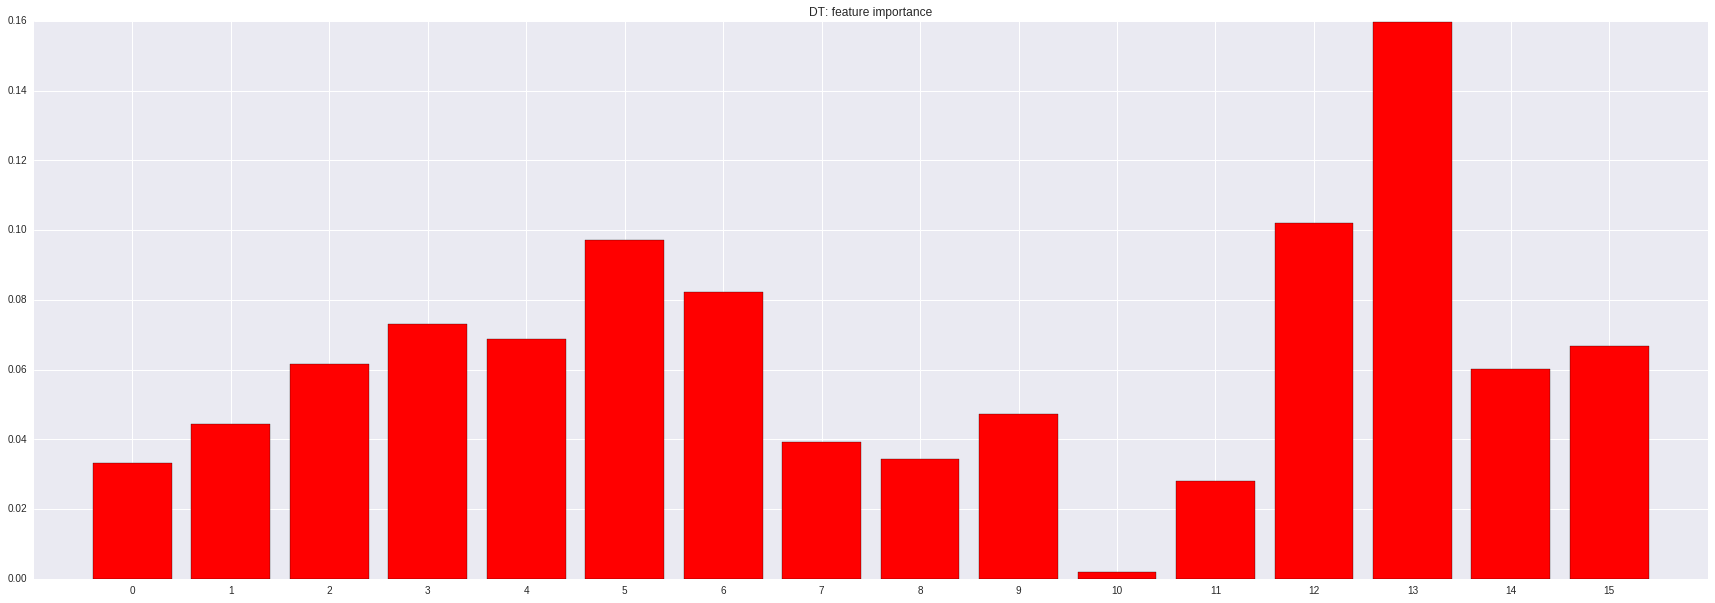

0 kills_per_min 0.0331564312155
1 deaths_per_min 0.0443847092227
2 assists_per_min 0.0616358715455
3 last_hits_per_min 0.0730131975096
4 denies_per_min 0.0687695208319
5 hero_dmg_per_min 0.0970601195518
6 tower_dmg_per_min 0.0823452615279
7 gold_spent_per_min 0.0392392683041
8 hero_lvl 0.0344106339122
9 xp_per_min 0.0471892951555
10 win 0.00196952074648
11 kda 0.027934872082
12 time_to_previous_match 0.102155625135
13 avg_time_between_session 0.159659934566
14 avg_session_length 0.0602622161996
15 number_sessions 0.066813522495


Evaluate DT
Confusion Matrix
[[13220   189]
 [  149     0]]


Accuracy
0.975070069332
Recall
0.0
Fall-Out
1.0
Miss Rate
0.0111451866258
Precision
0.0
F1-Measure
0.0


In [30]:
model = tree.DecisionTreeClassifier(class_weight="balanced")

print("Train DT")
train = model.fit(train_x, train_y)

print("Test DT")
pred = model.predict(test_x)

print("Feature Importance")
feature_importance(model.feature_importances_, "DT")
print("\n")

print("Evaluate DT")
evaluate_classifier(test_y, pred)

#### Random Forests

Train RF
Test RF
Feature Importance


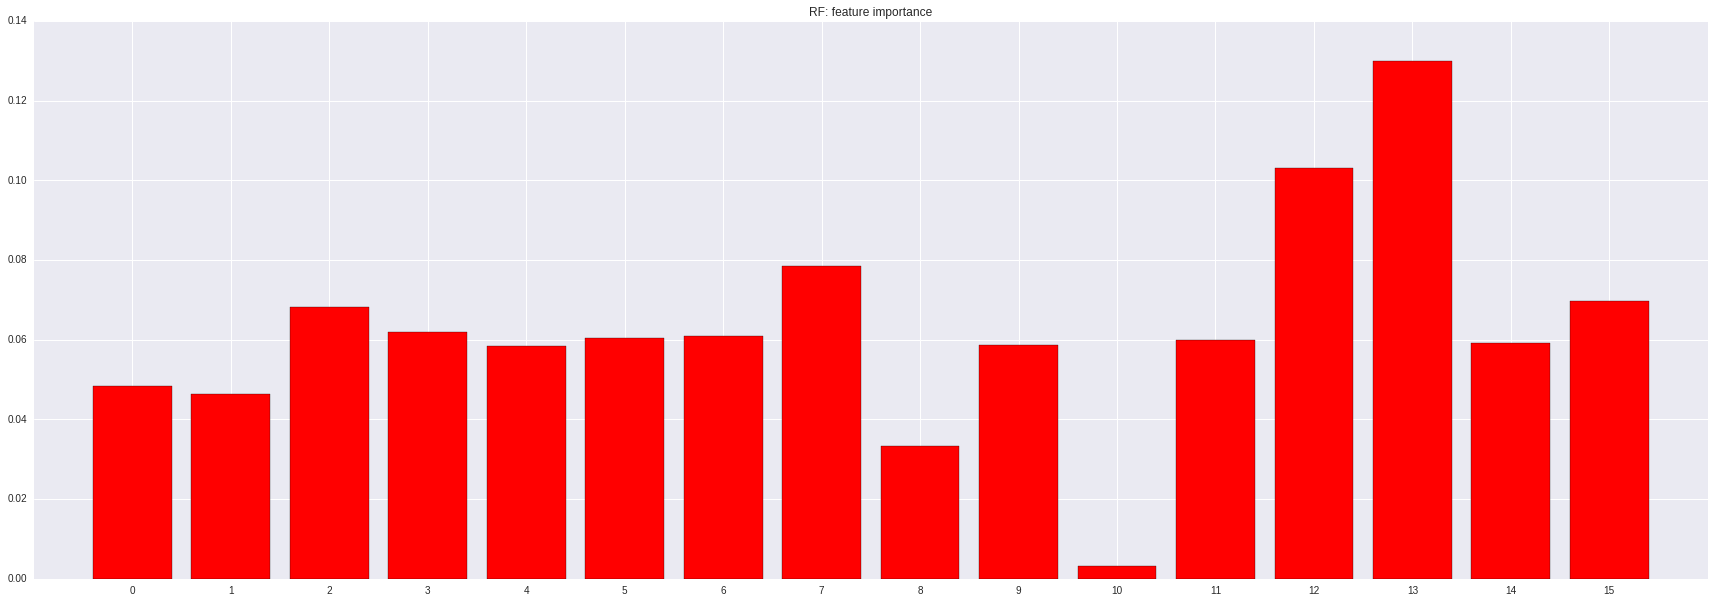

0 kills_per_min 0.0484188419314
1 deaths_per_min 0.0462856199053
2 assists_per_min 0.068157422204
3 last_hits_per_min 0.0618611034698
4 denies_per_min 0.0584034244063
5 hero_dmg_per_min 0.0604286438509
6 tower_dmg_per_min 0.0609394882826
7 gold_spent_per_min 0.0785000643158
8 hero_lvl 0.0333880144413
9 xp_per_min 0.0587827115906
10 win 0.00322202599024
11 kda 0.0599125478522
12 time_to_previous_match 0.102991648718
13 avg_time_between_session 0.12982612522
14 avg_session_length 0.059197395738
15 number_sessions 0.069684922084


Evaluate RF
Confusion Matrix
[[13409     0]
 [  149     0]]


Accuracy
0.989010178492
Recall
0.0
Fall-Out
nan
Miss Rate
0.0109898215076
Precision
0.0
F1-Measure
0.0


/home/dany/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dany/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
model = RandomForestClassifier(n_estimators=10, class_weight="balanced")

print("Train RF")
train = model.fit(train_x, train_y)

print("Test RF")
pred = model.predict(test_x)

print("Feature Importance")
feature_importance(model.feature_importances_, "RF")
print("\n")

print("Evaluate RF")

evaluate_classifier(test_y, pred)

#### Naive Bayes

In [32]:
model = GaussianNB()

print("Train NB")
train = model.fit(train_x, train_y)

print("Test NB")
pred = model.predict(test_x)

print("Evaluate NB")
evaluate_classifier(test_y, pred)

Train NB
Test NB
Evaluate NB
Confusion Matrix
[[13330    79]
 [  143     6]]


Accuracy
0.983625903526
Recall
0.0402684563758
Fall-Out
0.929411764706
Miss Rate
0.0106138202331
Precision
0.0705882352941
F1-Measure
0.0512820512821


### Discussion
All classifier except logistic regression have a nearly perfect accuracy but it isn't a good metric for unbalanced data. More important are precision and recall which are really low. Because of that logistic regression worked best on this data set even though it has a lower accuracy